TIMES series en ML


1) Comment entrainer un model de prediction dans le temps == Time series ?

    a) Toutes les variables sont elles inconnues au pas de temps suivant ?

    b) Comment travailler son dataset pour le mettre en forme

2) Quels sont les concepts usuels ?

    a) Datastet avec prediction pas à pas
    
    b) Modele d'interpretation de tendance (ARIMA / SARIMA)
    
    c) Modele avec mémoire integrée (LSTM / GRU)

## Deep Learning et réseau RNN (Recurent Neural Network)

L'objectif de cette manipulation est de vous montrer le potentiel du deep learning en NLP et plus particulirerment en NLG (Natural Language Generation)


#### Définition
Les réseaux de neurones récurrents, sont une classe de réseaux de neurones qui permettent aux prédictions antérieures d'être utilisées comme entrées, par le biais d'états cachés (en anglais hidden states)
Un RNN a la particularité d'avoir une memoire sur les bonnes predictions de la sequence de sortie (en fonction de la sequence d'entrée).
Les modèles RNN sont surtout utilisés dans les domaines du traitement automatique du langage naturel et de la reconnaissance vocale.


![Title](https://www.i2tutorials.com/wp-content/media/2019/09/Neural-network-62-i2tutorials.png)


![Title](https://miro.medium.com/max/600/1*pQ2tm6Mirdrf6hqwfYXb0g.gif)

#### Variantes aux RNNs traditionnels,
Les unités de porte récurrente (en anglais Gated Recurrent Unit) (GRU) et les unités de mémoire à long/court terme (en anglais Long Short-Term Memory units) (LSTM) où le LSTM peut être vu comme étant une généralisation du GRU. Ils apaisent le problème du "gradient qui disparait", rencontré par les RNNs traditionnels



#### Sequence to Sequence 

La séquence à séquence (Seq2Seq) consiste à entraîner des modèles pour convertir des séquences d'un domaine (par exemple des phrases en anglais) en séquences d'un autre domaine (par exemple les mêmes phrases traduites en français).

Cela peut être utilisé pour la traduction automatique ou pour la réponse aux questions sans réponse (générant une réponse en langage naturel à partir d'une question en langage naturel) - en général, il est applicable chaque fois que vous avez besoin de générer du texte.

Il existe plusieurs façons de gérer cette tâche, dont celle utilisant des RNN.



Dans le cas général, les séquences d'entrée et les séquences de sortie ont des longueurs différentes (par exemple, traduction automatique) et la séquence d'entrée entière est nécessaire pour commencer à prédire la cible. Cela nécessite une configuration plus avancée, ce à quoi les gens se réfèrent généralement lorsqu'ils mentionnent des «modèles de séquence à séquence» sans autre contexte. Voilà comment cela fonctionne:

+ Une couche RNN (ou plusieurs couches) joue le rôle d'"encodeur": elle traite la séquence d'entrée et renvoie son propre état interne. Notez que nous rejetons les sorties de l'encodeur RNN, ne **récupérant que l'état**. Cet état servira de "contexte", ou "conditionnement", du décodeur à l'étape suivante.

+ Une autre couche RNN (ou plusieurs couches) fait office de "décodeur": elle est entraînée pour prédire les caractères suivants de la séquence cible, étant donné les caractères précédents de la séquence cible. Plus précisément, il est formé pour transformer les séquences cibles en décalées d'un pas de temps dans le futur. Il est important de noter que l'encodeur utilise comme état initial les vecteurs d'état de l'encodeur, ce qui permet au décodeur d'obtenir des informations sur ce qu'il est censé générer. En effet, le décodeur apprend à générer des cibles [t + 1 ...] en fonction de [... t], conditionnées à la séquence d'entrée (hidden state).

Nous allons aborder les model de type sequence to sequence et en particulier le Long Short Term Memory (LSTM) tres utilisé egalement en Time series.

![ee](https://metalblog.ctif.com/wp-content/uploads/sites/3/2021/09/Les-differents-types-de-reseaux-de-neurones-RNN-LSTM-et-GRU-1024x307.jpg)

![Title](https://upload.wikimedia.org/wikipedia/commons/6/63/Long_Short-Term_Memory.svg)

Reprenons des analyses de pollution, celle de Pekin

"pollution.csv"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

#### Chargement du fichier

In [20]:
df=pd.read_csv('Data/pollution.csv',index_col=0,parse_dates=True)
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


#### Decomposition serie temporelle

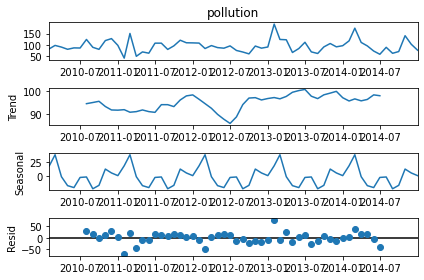

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

a=(df.resample('M')['pollution'].mean()).dropna()

decomp_x = seasonal_decompose(a,  model='additive')
decomp_x.plot()
plt.show()

#### Nettoyage Manipulation

Ajoutons les jours de la semaine ainsi que le numero de la semaine dans l'année comme variables explicatives à notre problème

In [22]:
df['jds']=df.index.weekday
df['week']=df.index.week

In [23]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,jds,week
year_month_day_hour,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,5,53
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,5,53
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,5,53
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,5,53
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,5,53


Mapping collone pollution'wnd_dir'

In [24]:
d=dict(zip(df['wnd_dir'].unique(),range(len(df['wnd_dir'].unique()))))
df['wnd_dir']=df['wnd_dir'].map(d)

#### Choix de la frequence d'echantillonage

ex: 

Je cherche à predire pour le mois suivant ==> resample('M')

Je cherche à predire pour la semaine suivante ==> resample('w')

In [26]:
df=df.resample('w').mean().dropna()

#### Creation des train test split

In [27]:
# Proportion
train_size = int(len(df)*0.8)

# Repartition
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

#### Normalisation

In [28]:
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)


#### Notion de sequence 

Construction d'une sequence d'observation 

Je créé un sequence de 6 observations chronologiques qui devront permettre de prédire la pollution de la 7eme

In [30]:

def create_dataset (X, look_back = 1):
    #output : X[samples, time steps, features], y[samples, features]
    
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back,0])
        
    return np.array(Xs), np.array(ys).reshape(-1,1)

X_train, y_train = create_dataset(train_scaled,3)
X_test, y_test = create_dataset(test_scaled,3)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (206, 3, 10)
y_train.shape:  (206, 1)
X_test.shape:  (50, 3, 10)
y_test.shape:  (50, 1)


#### Training 

In [31]:


# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1,activation='relu'))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(32)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 4)
    history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test,y_test),
                    batch_size = 16, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)

Epoch 1/100
13/13 [==============================] - 6s 106ms/step - loss: 0.0883 - val_loss: 0.0463
Epoch 2/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0338 - val_loss: 0.0347
Epoch 3/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0304 - val_loss: 0.0317
Epoch 4/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0244 - val_loss: 0.0300
Epoch 5/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0292 - val_loss: 0.0292
Epoch 6/100
13/13 [==============================] - 0s 30ms/step - loss: 0.0288 - val_loss: 0.0288
Epoch 7/100
13/13 [==============================] - 0s 39ms/step - loss: 0.0302 - val_loss: 0.0295
Epoch 8/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0245 - val_loss: 0.0304
Epoch 9/100
13/13 [==============================] - 0s 30ms/step - loss: 0.0321 - val_loss: 0.0294
Epoch 10/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0239 - val_loss: 0.029

#### Evaluation du modèle
Une fois le modèle ajusté, nous pouvons prévoir l'intégralité du jeu de données de test.

Nous utiliserons le RMSE.

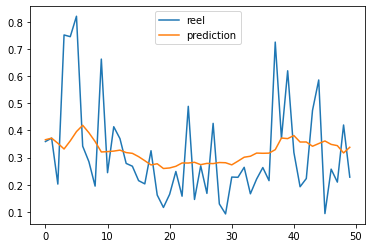

In [32]:

i=0
maxi=i+100
plt.plot(y_test[i:maxi],label="reel")
plt.plot(model_bilstm.predict(X_test)[i:maxi],label="prediction")
plt.legend()

Bidirectiona LSTM:
Mean Absolute Error: 32.1724
Root Mean Square Error: 41.1491



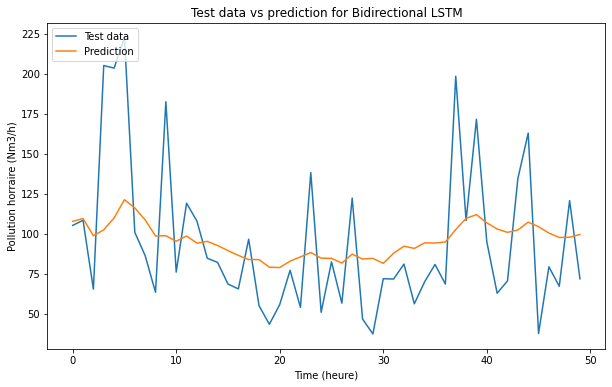

In [33]:


def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('loss_'+model_name+'.jpg', format='jpg', dpi=1000)


#plot_loss (history_bilstm, 'Bidirectional LSTM')

# Denormalisation (retour aux données originelles)
a_test=X_test[:,0,:]
a_test[:,0]=y_test.reshape(1,-1)

a_train=X_train[:,0,:]
a_train[:,0]=y_train.reshape(1,-1)

y_test = scaler.inverse_transform(a_test)[:,0]
y_train = scaler.inverse_transform(a_train)[:,0]

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    a_pred=X_test[:,0,:]
    a_pred[:,0]=prediction.reshape(1,-1)
    
    prediction = scaler.inverse_transform(a_pred)[:,0]
    return prediction


prediction_bilstm = prediction(model_bilstm)


def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (heure)')
    plt.ylabel('Pollution horraire (Nm3/h)')
       

plot_future(prediction_bilstm[-1000:], 'Bidirectional LSTM', y_test[-1000:])


# Calcule MAE et RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

In [34]:

from sklearn.metrics import mean_squared_error

rms = mean_squared_error(prediction_bilstm, y_test, squared=False)
rms

41.14907058568761

#### Essayons de predire la pollution sur plusieurs pas de temps

In [35]:

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)


In [36]:
def create_dataset (X, look_back,steps):
    #output : X[samples, time steps, features], y[samples, features]
    
    Xs, ys = [], []
    
    for i in range(len(X)-look_back-steps):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back:i+look_back+steps,0])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,6,3)
X_test, y_test = create_dataset(test_scaled,6,3)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (200, 6, 10)
y_train.shape:  (200, 3)
X_test.shape:  (44, 6, 10)
y_test.shape:  (44, 3)


In [37]:
# Create BiLSTM model
def create_bilstm(units,out):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(out))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(96,y_test[0].shape[0])

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 3)
    history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test,y_test),
                    batch_size = 32, shuffle = True, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)

Epoch 1/100
7/7 [==============================] - 6s 267ms/step - loss: 0.0850 - val_loss: 0.0499
Epoch 2/100
7/7 [==============================] - 1s 117ms/step - loss: 0.0386 - val_loss: 0.0352
Epoch 3/100
7/7 [==============================] - 0s 73ms/step - loss: 0.0367 - val_loss: 0.0296
Epoch 4/100
7/7 [==============================] - 1s 87ms/step - loss: 0.0284 - val_loss: 0.0303
Epoch 5/100
7/7 [==============================] - 2s 300ms/step - loss: 0.0304 - val_loss: 0.0300
Epoch 6/100
7/7 [==============================] - 1s 190ms/step - loss: 0.0270 - val_loss: 0.0309


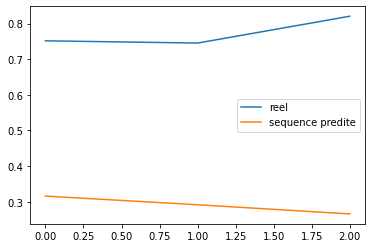

In [38]:
i=0
 
predict= model_bilstm.predict(X_test)
plt.plot(y_test[i,:],label="reel")
plt.plot(predict[i,:],label="sequence predite")
plt.legend()

#### Refaite cette etude en echantillonnant par jour

Vous predirez la pollution moyenne du jour suivant

In [ ]:
df=pd.read_csv('pollution.csv',index_col=0,parse_dates=True)
df['week']=df.index.week
d=dict(zip(df['wnd_dir'].unique(),range(len(df['wnd_dir'].unique()))))
df['wnd_dir']=df['wnd_dir'].map(d)


df=df.resample('d').mean().dropna()

# Proportion
train_size = int(len(df)*0.8)

# Repartition
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Normalisation
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

#scaler_y=MinMaxScaler().fit(y_train.values.reshape(-1, 1))
#y_train=scaler_y.transform(y_train.values.reshape(-1, 1))
#y_test=scaler_y.transform(y_test.values.reshape(-1, 1))


def create_dataset (X, look_back = 1):
    #output : X[samples, time steps, features], y[samples, features]
    
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back,0])
        
    return np.array(Xs), np.array(ys).reshape(-1,1)

X_train, y_train = create_dataset(train_scaled,100)
X_test, y_test = create_dataset(test_scaled,100)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

In [ ]:


# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(32)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 5)
    history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test,y_test),
                    batch_size = 16, shuffle = True, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)

In [ ]:

def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('loss_'+model_name+'.jpg', format='jpg', dpi=1000)


#plot_loss (history_bilstm, 'Bidirectional LSTM')

# Denormalisation (retour aux données originelles)
a_test=X_test[:,0,:]
a_test[:,0]=y_test.reshape(1,-1)

a_train=X_train[:,0,:]
a_train[:,0]=y_train.reshape(1,-1)

y_test = scaler.inverse_transform(a_test)[:,0]
y_train = scaler.inverse_transform(a_train)[:,0]

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    a_pred=X_test[:,0,:]
    a_pred[:,0]=prediction.reshape(1,-1)
    
    prediction = scaler.inverse_transform(a_pred)[:,0]
    return prediction


prediction_bilstm = prediction(model_bilstm)


def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (semaine)')
    plt.ylabel('Pollution moyenne (Nm3/h)')
       

plot_future(prediction_bilstm[:500], 'Bidirectional LSTM', y_test[:500])


# Calcule MAE et RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

#### Refaite cette etude en echantillonnant par semaine (puis par mois)

Vous predirez la pollution moyenne de la semaine suivante et comparer vos resultats avec ceux du modele ARIMA

In [ ]:
df=pd.read_csv('pollution.csv',index_col=0,parse_dates=True)
df['week']=df.index.week
d=dict(zip(df['wnd_dir'].unique(),range(len(df['wnd_dir'].unique()))))
df['wnd_dir']=df['wnd_dir'].map(d)


df=df.resample('M').mean().dropna()

# Proportion
train_size = int(len(df)*0.7)

# Repartition
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Normalisation
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

#scaler_y=MinMaxScaler().fit(y_train.values.reshape(-1, 1))
#y_train=scaler_y.transform(y_train.values.reshape(-1, 1))
#y_test=scaler_y.transform(y_test.values.reshape(-1, 1))


def create_dataset (X, look_back = 1):
    #output : X[samples, time steps, features], y[samples, features]
    
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back,0])
        
    return np.array(Xs), np.array(ys).reshape(-1,1)

X_train, y_train = create_dataset(train_scaled,12)
X_test, y_test = create_dataset(test_scaled,12)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

In [ ]:

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(32)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test,y_test),
                    batch_size = 16, shuffle = True, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)

In [ ]:

i=0
maxi=i+20
plt.plot(y_test[i:maxi],label="reel")
plt.plot(model_bilstm.predict(X_test)[i:maxi],label="prediction")
plt.legend()

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('loss_'+model_name+'.jpg', format='jpg', dpi=1000)


#plot_loss (history_bilstm, 'Bidirectional LSTM')

# Denormalisation (retour aux données originelles)
a_test=X_test[:,0,:]
a_test[:,0]=y_test.reshape(1,-1)

a_train=X_train[:,0,:]
a_train[:,0]=y_train.reshape(1,-1)

y_test = scaler.inverse_transform(a_test)[:,0]
y_train = scaler.inverse_transform(a_train)[:,0]

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    a_pred=X_test[:,0,:]
    a_pred[:,0]=prediction.reshape(1,-1)
    
    prediction = scaler.inverse_transform(a_pred)[:,0]
    return prediction


prediction_bilstm = prediction(model_bilstm)


def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (heure)')
    plt.ylabel('Pollution horraire (Nm3/h)')
       

plot_future(prediction_bilstm[-1000:], 'Bidirectional LSTM', y_test[-1000:])


# Calcule MAE et RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

#### Amélioration / Analyse :

- Introduisez des variables calendaires (jour de la semaine, numero de la semaine, ...)


- Essayer de predire la journée suivante (j+1), puis j+2 et enfin j+3
    - Extraire les rmse pour ces predictions 
    - Quelles conclusions ?

- Vous pouvez travailler sur des resaux différents (toujours en LSTM)

- Et les hypers parametres ?
